# Notebook for creating the TfIdf Embeddings of the Story feature

## Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Project/KickLearning/

/content/drive/.shortcut-targets-by-id/1iWelwZQ6yutjZacqvhb1xSPIvi_nlIiH/Project/KickLearning


Lybraries

In [3]:
from os.path import join

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

from time import time


import sklearn

import re

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import sklearn
import seaborn as sns

torch.manual_seed(0)

### Loading the Dataset

In [4]:
data_path = join(".", "data")
checkpoints = join(".", "logs", "checkpoints_nn_classification")

In [5]:
data = pd.read_csv(join(data_path, "final_dataset.csv"))
data = data[data['state'].isin(['successful', 'failed'])]

In [7]:
def fun(j):
    return re.findall(r'\'(\b\w+\b)\'', j) + list(map(lambda x: x[0]+" " +x[1], re.findall(r"\"(\w+).*?(\w \w+)\"", j)))

data['category'] = data['category'].apply(fun)
data['sub_category'] = data['sub_category'].apply(fun)
data['category_2'] = data['category'].apply(lambda x: str(x[1]) if len(x)>1 else 'No category')
#data['category_3'] = data['category'].apply(lambda x: str(x[2]) if len(x)>2 else 'No category')
data['category'] = data['category'].apply(lambda x: str(x[0]) if len(x)>0 else 'No category')
data['sub_category'] = data['sub_category'].apply(lambda x: x[0] if len(x)>0 else 'No sub_category')

data['duration'] = data['deadline']-data['launched_at']
data['usd_goal'] = data['goal']*data['fx_rate']
data['state'] = data['state'].apply(lambda x: 1 if x=='successful' else 0)
# data = data[data['usd_pledged'] >= 1]

In [8]:
# simplest feature work
#data['currency'] = data['currency'].astype('category').cat.codes
#data['country'] = data['country'].astype('category').cat.codes
#data['category'] = data['category'].astype('category').cat.codes
#data['sub_category'] = data['sub_category'].astype('category').cat.codes

data_class = data.drop(columns=['id', 'project_url', 'image', 'goal', 'fx_rate', 'state', 'launched_at', 'deadline'])
data = data.drop(columns=['id', 'project_url', 'image', 'goal', 'fx_rate', 'launched_at', 'deadline', 'usd_pledged'])

#data_class = data_class.drop(columns=[i for i in data.columns if 'historical' in i])
data_class = data_class.dropna(axis = 0, how ='any')

#data = data.drop(columns=[i for i in data.columns if 'historical' in i])
data = data.dropna(axis = 0, how ='any')

## Balancing calsses

In [9]:
train_df, test_df, train_target, test_target =  train_test_split(data.drop(columns=['state']), 
                                                                     data['state'],
                                                                     test_size=0.2, random_state=1234)

In [10]:
oversample_df = train_df[train_target==0].sample(n=(train_target==1).sum()-(train_target==0).sum(), replace=True)
oversample_target = pd.Series(np.zeros(len(oversample_df)))

In [11]:
train_df = train_df.append(oversample_df)
train_target = train_target.append(oversample_target)

## Scaling the dataset

In [12]:
num_cols = train_df.columns[train_df.dtypes.apply(lambda c: np.issubdtype(c, np.number))]

In [13]:
scaler = StandardScaler()
train_df[num_cols] = scaler.fit_transform(train_df[num_cols])
test_df[num_cols] = scaler.transform(test_df[num_cols])

In [14]:
train_reg_X, test_reg_X, train_reg_y, test_reg_y = train_df.to_numpy(), test_df.to_numpy(), train_target.to_numpy(), test_target.to_numpy()

## Encoding categorical the features

In [15]:
arr = train_reg_X.copy() 
categorical_feat = train_df.columns[train_df.dtypes.apply(lambda c: not np.issubdtype(c, np.bool) and not np.issubdtype(c, np.number))]
categorical_features = [i for i,col in enumerate(data.drop(columns=['state']).columns) if col in categorical_feat]
categorical_names = {}
for feature in categorical_features:
    le = sklearn.preprocessing.LabelEncoder()
    #print(feature)
    le.fit(np.array(data.drop(columns=['state']))[:, feature])
    train_reg_X[:, feature] = le.transform(train_reg_X[:, feature])
    test_reg_X[:, feature] = le.transform(test_reg_X[:, feature])
    #print(le.classes_)
    categorical_names[feature] = le.classes_

for k, v in categorical_names.items():
    categorical_names[k] = list(arr[:, k])

In [16]:
train_x, val_x, train_y, val_y = train_test_split(train_reg_X, train_reg_y, test_size=0.2, random_state=1234)

In [17]:
test_x, test_y = test_reg_X, test_reg_y

In [18]:
train_dataset = TensorDataset(torch.Tensor(train_x.astype("float32")), torch.Tensor(train_y.astype("float32")))
val_dataset = TensorDataset(torch.Tensor(val_x.astype("float32")), torch.Tensor(val_y.astype("float32")))
test_dataset = TensorDataset(torch.Tensor(test_x.astype("float32")), torch.Tensor(test_y.astype("float32")))

train_dataloader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=64)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=64)

## Embedding Data

In [51]:
class DeepRegressor(nn.Module):
        def __init__(self, input_size, hidden_size, n_hidden_layers=5):
            super(DeepRegressor, self).__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.num_hidden_layers = n_hidden_layers


            self.first_layer = nn.Sequential(nn.Linear(self.input_size, self.hidden_size),
                                             nn.BatchNorm1d(self.hidden_size),
                                             nn.ReLU(),
                                             nn.Dropout(0.01))

            self.hidden_layers = nn.Sequential()
            for _ in range(self.num_hidden_layers):
                self.hidden_layers.add_module("linear", nn.Linear(self.hidden_size, self.hidden_size))
                self.hidden_layers.add_module("batch_norm", nn.BatchNorm1d(self.hidden_size))
                self.hidden_layers.add_module("activation", nn.ReLU())
                self.hidden_layers.add_module("dropout", nn.Dropout(0.01))
            
            self.last_layer1 = nn.Sequential(nn.Linear(self.hidden_size, int(self.hidden_size/2)),
                                             nn.BatchNorm1d(int(self.hidden_size/2)),
                                             nn.ReLU(),
                                             nn.Dropout(0.01))
            self.last_layer2 = nn.Linear(int(self.hidden_size/2), 1)

        def forward(self, x):
            hidden_state = self.first_layer(x)
            x = self.hidden_layers(hidden_state)
            x = self.last_layer1(x)
            output = self.last_layer2(x)
            return output.squeeze(1)

In [121]:
model = DeepRegressor(train_x.shape[1], 32, n_hidden_layers=4)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.002)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10, 15], gamma=0.5)

In [122]:
for param in model.parameters():
    param.requires_grad = True

epochs = 25
k_best_models = 4
loss_history = {"train": [], "val": []}
best_models_df = pd.DataFrame()

start_training = time()
for epoch in range(epochs):
    start_epoch = time()
    model.train()
    loss_history["train"].append(0)
    accuracy = 0
    for i, batch in enumerate(train_dataloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch

        optimizer.zero_grad()
        # Forward pass
        y_pred = model(inputs)
        # Compute Loss
        loss = criterion(y_pred, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        loss_history["train"][epoch] += loss.item()/len(train_dataloader)
        accuracy += ((y_pred > 0.5) == labels).sum()/labels.size(0)/len(train_dataloader)

    print(f"\n------> Epoch {epoch+1} <------\n    Train CossEntrpy loss: {loss_history['train'][epoch]}, Accuracy: {accuracy}")
    
    model.eval()
    loss_history["val"].append(0)
    accuracy = 0
    for i, batch in enumerate(val_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch
        with torch.no_grad():
            y_pred = model(inputs)

        # forward + backward + optimize
        loss_history["val"][epoch] += criterion(y_pred, labels).item()/len(val_dataloader)
        accuracy += ((y_pred > 0.5) == labels).sum()/labels.size(0)/len(val_dataloader)

    print(f"    Val   CossEntrpy loss: {loss_history['val'][epoch]}, Accuracy: {accuracy}")

    # check for overfitting:
    early_stopping_steps = 5
    if len(loss_history["val"]) > 4 and \
            all(map(lambda x: x[0]<x[1], zip(loss_history["val"][-(early_stopping_steps)-1:-1], loss_history["val"][-(early_stopping_steps):]))) and \
            all(map(lambda x: x[0]>x[1], zip(loss_history["train"][-(early_stopping_steps)-1:-1], loss_history["train"][-(early_stopping_steps):]))):
        break

    best_models_df = best_models_df.append({"loss": loss_history["val"][epoch], "epoch": epoch, "state_dict": model.state_dict()}, ignore_index=True).sort_values("loss", ignore_index=True).head(k_best_models)

    scheduler.step()
    print(f"    Epoch time: {round((time()-start_epoch)//60)}m {round((time()-start_epoch)%60)}s")

print('\n\n****************** Finished Training ******************')
print(f"Time elapsed for training: {round((time()-start_training)//60)}:{round((time()-start_training)%60)}")


------> Epoch 1 <------
    Train CossEntrpy loss: 0.4577585195964504, Accuracy: 0.7675721645355225
    Val   CossEntrpy loss: 0.43097247637196917, Accuracy: 0.7772207260131836
    Epoch time: 0m 4s

------> Epoch 2 <------
    Train CossEntrpy loss: 0.4222833646645303, Accuracy: 0.7914484739303589
    Val   CossEntrpy loss: 0.42194100377125254, Accuracy: 0.7905966639518738
    Epoch time: 0m 4s

------> Epoch 3 <------
    Train CossEntrpy loss: 0.4132315009956728, Accuracy: 0.7969350814819336
    Val   CossEntrpy loss: 0.4064925267401264, Accuracy: 0.8003718256950378
    Epoch time: 0m 4s

------> Epoch 4 <------
    Train CossEntrpy loss: 0.40690234614347026, Accuracy: 0.800594687461853
    Val   CossEntrpy loss: 0.40525459256722657, Accuracy: 0.7996306419372559
    Epoch time: 0m 4s

------> Epoch 5 <------
    Train CossEntrpy loss: 0.40235094925044146, Accuracy: 0.8037187457084656
    Val   CossEntrpy loss: 0.4013926135855356, Accuracy: 0.8154486417770386
    Epoch time: 0m 4s



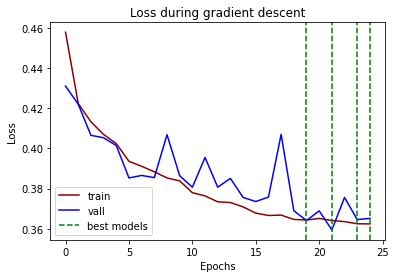

In [123]:
plt.title("Loss during gradient descent")
plt.plot(range(epochs), loss_history["train"], label="train", color="darkred")
plt.plot(range(epochs), loss_history["val"], label="vall", color="blue")
for i, best_epoch in best_models_df["epoch"].iteritems():
    plt.axvline(best_epoch, ls="--", label="best models" if i==0 else None, color="green")
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()

## Testing the Best Models

In [131]:
model.eval()
test_accuracies = []
for index, (epoch, state_dict) in best_models_df[["epoch", "state_dict"]].iterrows():
    model.load_state_dict(state_dict)

    test_y_pred = []
    test_y_true = []
    start = time()
    for i, batch in enumerate(test_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch
        with torch.no_grad():
            outputs = model(inputs)

        test_y_pred.append(outputs)
        test_y_true.append(labels)

    test_y_pred = torch.cat(test_y_pred)
    test_y_true = torch.cat(test_y_true)
    loss = (criterion(test_y_pred, test_y_true).sqrt().mean(dim=0)).item()
    accuracy = ((test_y_pred > 0.5) == test_y_true).sum()/test_y_true.size(0)

    test_accuracies.append(accuracy.item())

    print(f'****************** Finished Testing for model {index} saved at epoch {epoch} ******************')
    print(f"Test   CossEntrpy loss: {loss}, Accuracy: {accuracy}")
    print(f"Time elapsed for testing: {round((time()-start)//60)}:{round((time()-start)%60)}")

best_models_df["test_acc"] = test_accuracies

****************** Finished Testing for model 0 saved at epoch 21.0 ******************
Test   CossEntrpy loss: 0.6138644218444824, Accuracy: 0.7929906249046326
Time elapsed for testing: 0:0
****************** Finished Testing for model 1 saved at epoch 19.0 ******************
Test   CossEntrpy loss: 0.6138644218444824, Accuracy: 0.7929906249046326
Time elapsed for testing: 0:0
****************** Finished Testing for model 2 saved at epoch 23.0 ******************
Test   CossEntrpy loss: 0.6138644218444824, Accuracy: 0.7929906249046326
Time elapsed for testing: 0:0
****************** Finished Testing for model 3 saved at epoch 24.0 ******************
Test   CossEntrpy loss: 0.6138644218444824, Accuracy: 0.7929906249046326
Time elapsed for testing: 0:0


In [125]:
best_models_df = best_models_df.sort_values(by="test_acc", ascending=False, ignore_index=True)
torch.save(best_models_df.loc[0, "state_dict"], join(checkpoints, f"model_with_acc_{str(best_models_df.loc[0, 'test_acc'])[2:7]}.pt"))
best_models_df.drop(columns="state_dict")

,epoch,loss,test_acc
0,21.0,0.359409,0.792991
1,19.0,0.364090,0.792991
2,23.0,0.364539,0.792991
3,24.0,0.365167,0.792991


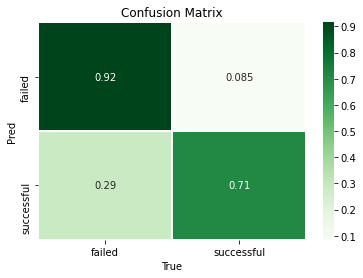

In [126]:
conf_mat = confusion_matrix(test_y_true, (test_y_pred.numpy() > 0.5)*1, normalize="true")
ax = sns.heatmap(conf_mat, linewidth=0.5, xticklabels=['failed', 'successful'], yticklabels=['failed', 'successful'], cmap='Greens', annot=True)
plt.title("Confusion Matrix")
plt.xlabel("True")
plt.ylabel("Pred")
plt.show()